In [1]:
import os,sys
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import crispat as cr
import matplotlib.pyplot as plt
import anndata as ad
import scipy as sp
from plotnine import *
from functools import reduce
from statsmodels.stats.multitest import multipletests
from pathlib import Path
from tqdm.auto import tqdm
import re
import glob

# module_dir = os.path.abspath(os.path.join('/Users/chandrima.modak/ron_perturb_seq_analysis/GWT_perturbseq_analysis/src', '1_preprocess'))
# sys.path.insert(0, module_dir)
# import preprocess
# import sgrna_assignment

In [2]:
experiment_info = pd.read_csv('/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/gw-CRISPRa_from_cluster/h5ad_raw_files_info.csv')
experiment_info = experiment_info.loc[:, ~experiment_info.columns.str.startswith("Unnamed")]
experiment_info.columns

Index(['lane1', 'lane2', 'lane3', 'lane4', 'lane5', 'lane6', 'lane7', 'lane8'], dtype='object')

In [3]:
name = []
for row in experiment_info.itertuples(index=False):
    tmp = []
    for k, v in row._asdict().items():
        t = v+'_'+k
        tmp.append(t)
    name.append(tmp)

In [4]:
def classify_sgrna(df):
    df['sgRNA_type'] = 'Single sgRNA'
    # overwrite where gRNA is missing
    df.loc[df['guide_id'].isna(), 'sgRNA_type'] = 'no sgRNA'
    df.loc[df['guide_id'].str.startswith('NTC', na=False), 'sgRNA_type'] = 'single NTC sgRNA'
    df.loc[df_guide['guide_id'].str.startswith('multi', na=False), 'sgRNA_type'] = 'multi sgRNA'
    # Order the rows
    type_order = ['Single sgRNA','single NTC sgRNA','multi sgRNA','no sgRNA']
    df['sgRNA_type'] = pd.Categorical(df['sgRNA_type'],categories=type_order,ordered=True)
    df = df.loc[:, ['lane_id','gRNA', 'guide_id', 'UMI_counts', 'target_gene','sgRNA_type']]
    return df

In [6]:
df1 = pd.DataFrame()
for i in range(0,len(name)):
    df = pd.DataFrame()
    for j in name[i]:
        path = f'/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/gw-CRISPRa_from_cluster/{j}/'
        guide_pattern = glob.glob(os.path.join(path, "*_gex_guide.h5ad"))[0]
        adata = sc.read_h5ad(os.path.join(path, guide_pattern))
        df_guide = adata.obs
        df_guide = classify_sgrna(df_guide)
        # df_guide['donor'] = j.split('_')[0]
        df_guide['construct'] = '_'.join(j.split('_')[:3])
        # df_guide['condition'] = j.split('_')[2]
        df = pd.concat([df, df_guide])
    df1 = pd.concat([df1, df])

In [7]:
def plot_lane_sgRNA(df):
    p = (ggplot(df,
               aes(x = 'construct', fill = 'sgRNA_type'))+
        geom_bar(position="stack")+
        scale_fill_brewer(type='sequential', palette= 5, direction= -1)+
        theme_bw()+
        theme(figure_size=(5, 3), dpi=150,axis_text_x=element_text(rotation=90, hjust=1)))
    return p

/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 5 x 3 in image.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/gw-CRISPRa_from_cluster/plots/guide_distribution.png


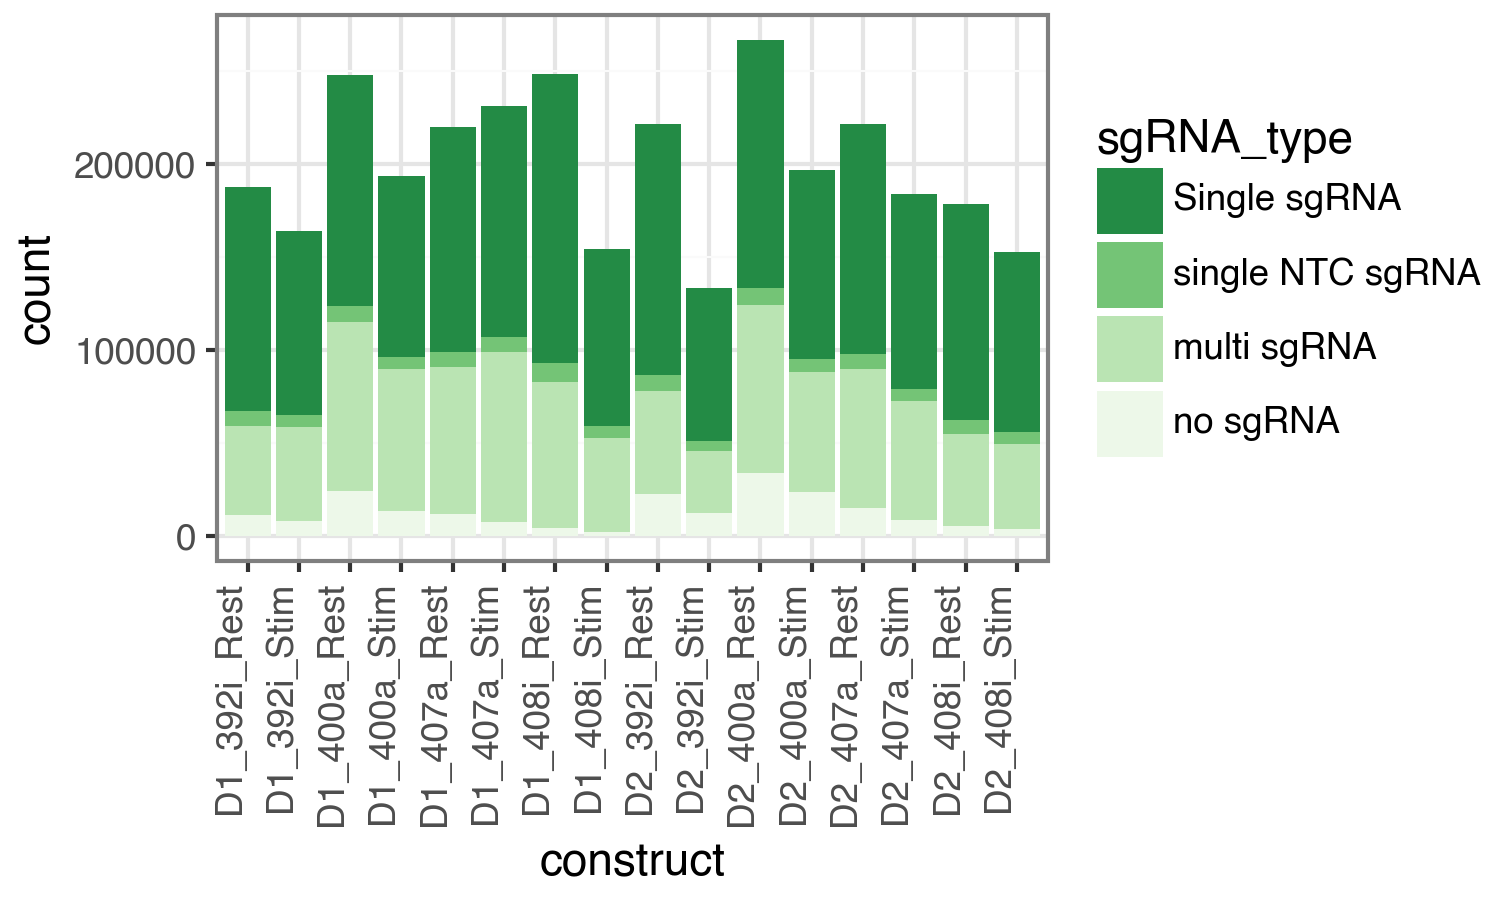

In [8]:
plot_pth = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/gw-CRISPRa_from_cluster/plots/'
os.makedirs(plot_pth, exist_ok= True)
plot_dis = plot_lane_sgRNA(df1)
plot_dis.save(os.path.join(plot_pth, 'guide_distribution.png'))
plot_dis